# Loading Libraries

In [1]:
!pip install seaborn==0.11.0

# General Data Manipulation Library
import pandas as pd
import numpy as np
import re


# Plotting LIbraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')
import random

random.seed(1455)
np.random.seed(1455)

from sklearn.metrics import accuracy_score

sns.set_theme()
clear_output()

# Loading Data

In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Here is the Data Dictionary to Understand what those Features mean

|Variable|Definition	|Key|
|:--|:--|:--|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	Sex	||
|Age|	Age in years|	|
|sibsp|	# of siblings / spouses aboard the Titanic	||
|parch|	# of parents / children aboard the Titanic	||
|ticket|	Ticket number	||
|fare|	Passenger fare	||
|cabin|	Cabin number|	|
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

### Variable Notes
* **pclass:** A proxy for socio-economic status (SES)
> 1st = Upper <br>
> 2nd = Middle <br>
> 3rd = Lower <br>

* **age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* **sibsp:** The dataset defines family relations in this way...
> Sibling = brother, sister, stepbrother, stepsister <br>
> Spouse = husband, wife (mistresses and fiancés were ignored)

* **parch:** The dataset defines family relations in this way...
> Parent = mother, father <br>
> Child = daughter, son, stepdaughter, stepson <br>
> Some children travelled only with a nanny, therefore parch=0 for them.

# <font color='blue'> Data Cleaning & Feature Engineering

### 1. Dealing with the Ticket Number:
Though at first look it might seem quite obvious that these bogus ticket numbers are rubbish and they dont mean anything. However, on the careful observatrion, it seems that these ticket numbers have some predictive power. Removing them will be a absolute loss for final prediction. So we will categorize the tickets based on the first 3 chracters of the ticket. The following block of code at first takes first 3 characters of the field `Ticket` and makes a categorical feature from them. 

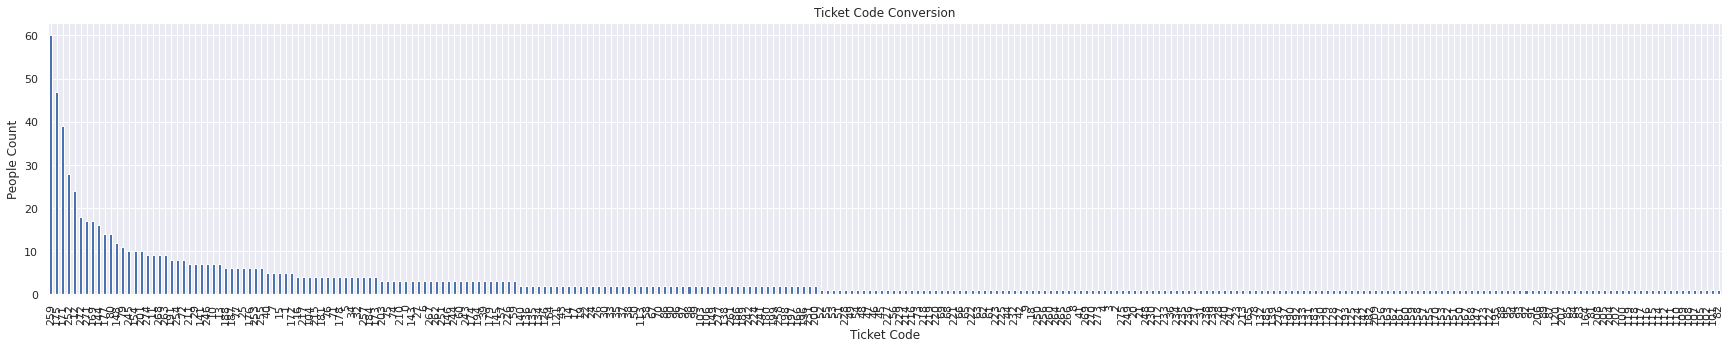

In [3]:
# Dealing with the Ticket
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:4])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:4])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

train['Ticket_type'].value_counts().plot.bar(figsize=(30, 5), title = 'Ticket Code Conversion', xlabel = 'Ticket Code', ylabel = 'People Count')

### 2. Synthetic Feature <font color='red'> [Words_Count] </font>

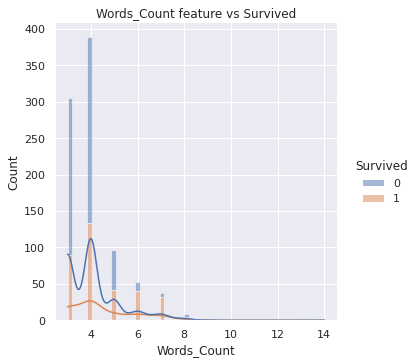

In [4]:
train['Words_Count'] = train['Name'].apply(lambda x: len(x.split()))
test['Words_Count'] = test['Name'].apply(lambda x: len(x.split()))

fig = sns.displot(data=train, x="Words_Count", hue="Survived", multiple="stack", kde = True)
fig.set(title='Words_Count feature vs Survived')

### 2. Synthetic Feature <font color='red'> [Has_Cabin] </font>
It seems that those who had cabin, survival rate among them was higher. 

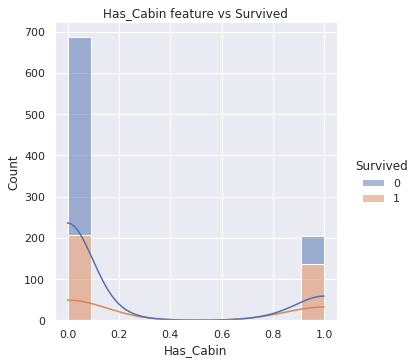

In [5]:
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

fig = sns.displot(data=train, x="Has_Cabin", hue="Survived", multiple="stack", kde = True)
fig.set(title='Has_Cabin feature vs Survived')

### 3. Synthetic Feature <font color='red'> [FamilySize] </font>

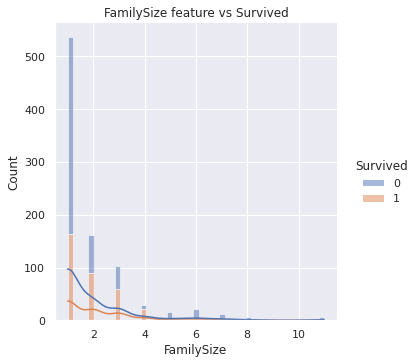

In [6]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

fig = sns.displot(data=train, x="FamilySize", hue="Survived", multiple="stack", kde = True)
fig.set(title='FamilySize feature vs Survived')

### 4. Synthetic Feature <font color='red'> [IsAlone] </font>

In [7]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

### 5. Synthetic Feature <font color='red'> [CategoricalFare] </font>

In [8]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

### 6. Synthetic Feature <font color='red'> [CategoricalAge] </font>

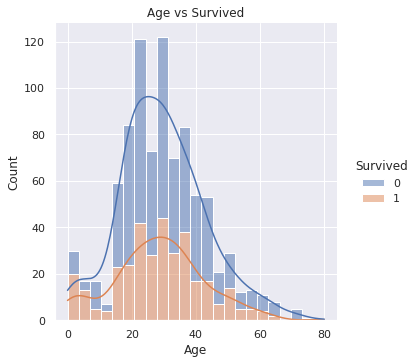

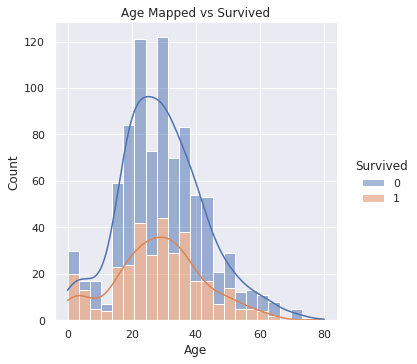

In [9]:
whole_data  = [train, test]

for dataset in whole_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)




fig = sns.displot(data=train, x="Age", hue="Survived", multiple="stack", kde = True)
fig.set(title='Age vs Survived')



# Mapping Age
dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

fig = sns.displot(data=train, x="Age", hue="Survived", multiple="stack", kde = True)
fig.set(title='Age Mapped vs Survived')

### 7. Synthetic Feature <font color='red'> [Title] </font>
We know that in the early twentith century, title meant social status and in titanic survival peoples' social status played a major role in prioratizing who will board on the life saving ship before or after. 

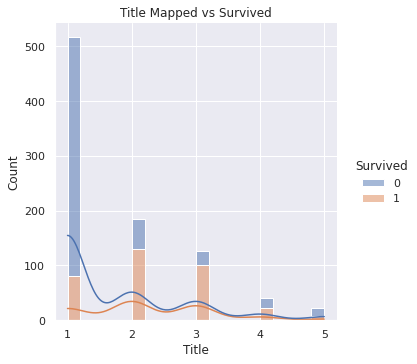

In [10]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in whole_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in whole_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    
for dataset in whole_data:
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
fig = sns.displot(data=train, x="Title", hue="Survived", multiple="stack", kde = True)
fig.set(title='Title Mapped vs Survived')

### 8. Processing Fare and Sex Feature <font color='red'> [Title] </font>

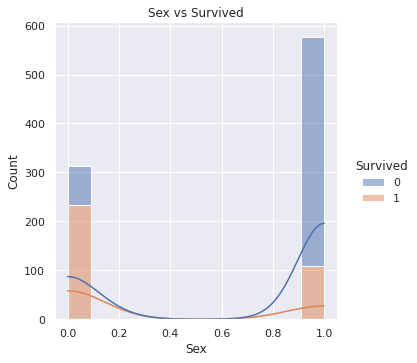

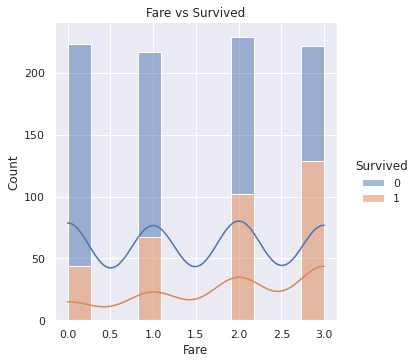

In [11]:
for dataset in whole_data:
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
# Mapping Sex [Male: 1, Female: 0]
for dataset in whole_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

fig = sns.displot(data=train, x="Sex", hue="Survived", multiple="stack", kde = True)
fig.set(title='Sex vs Survived')


fig = sns.displot(data=train, x="Fare", hue="Survived", multiple="stack", kde = True)
fig.set(title='Fare vs Survived')

### 9. Processing Feature <font color='red'>Embarked</font>

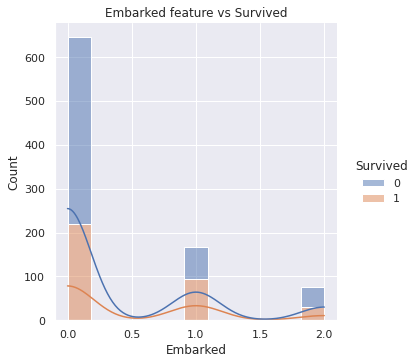

In [12]:
# Taking Care of the Missing Values
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')
    
# Mapping Embarked
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

fig = sns.displot(data=train, x="Embarked", hue="Survived", multiple="stack", kde = True)
fig.set(title='Embarked feature vs Survived')

### 10. Final Feature Selection: 


In [13]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,22,0,0,0,245,4,0,2,0,1
1,1,1,0,38,0,3,1,259,7,1,2,0,3
2,1,3,0,26,0,1,0,272,3,0,1,1,2
3,1,1,0,35,0,3,0,13,7,1,2,0,3
4,0,3,1,35,0,1,0,206,4,0,1,1,1


### 11. <font color='blue'> Correlation (Pearson) </font>
A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between two variables or features. The variables may be two columns of a given data set of observations, often called a sample, or two components of a multivariate random variable with a known distribution. 

Pearson correlation coefficient `(r)`: 

<font color='blue'> $$r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$$ </font>
where <br>
$r$	=	correlation coefficient <br>
$x_{i}$	=	values of the x-variable in a sample<br>
$\bar{x}$	=	mean of the values of the x-variable<br>
$y_{i}$	=	values of the y-variable in a sample<br>
$\bar{y}$	=	mean of the values of the y-variable

Let's have a look at the correlation of all the features. 


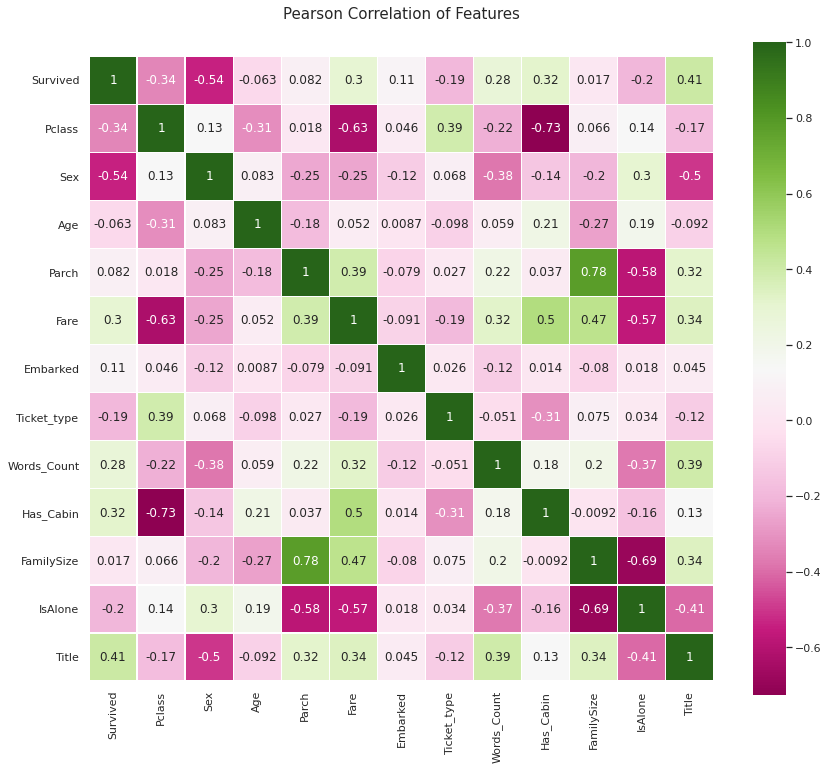

In [14]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.3,vmax=1.0, 
            square=True, cmap='PiYG', linecolor='white', annot=True)

### 12. <font color='blue'> Spearman's Rank Correlation </font>
In statistics, Spearman's rank correlation coefficient or Spearman's $rho\ (\rho)$ named after Charles Spearman and often denoted by the Greek letter or as, is a nonparametric measure of rank correlation. It assesses how well the relationship between two variables can be described using a monotonic function. 

$$\rho=1-\frac{6 \sum d_{i}^{2}}{n (n^{2}-1)}$$
where, <br>
$\rho	$ =	Spearman's rank correlation coefficient <br>
$d_{i}	$ =	difference between the two ranks of each observation <br>
$n	$ =	number of observations


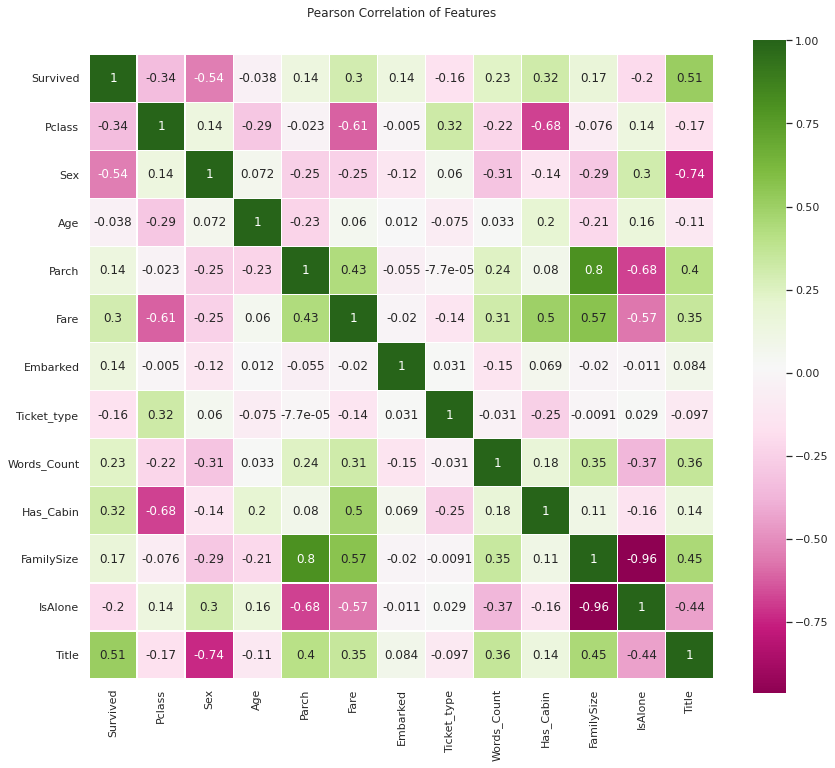

In [15]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=12)
sns.heatmap(train.astype(float).corr(method = 'spearman'),linewidths=0.3,vmax=1.0, 
            square=True, cmap='PiYG', linecolor='white', annot=True)

### 13. Comparison between Pearson and Spearman Correlation of Features. 
In order to understand this comparison, please have a look at this [small article](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.)

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

However, in the Spearman Correlation Features, it shows a number of features which are correlated. The reason here is that Spearman mainly finds out the correlation among the ordinal features where Pearson Correlation finds the correlation among the linear data. 


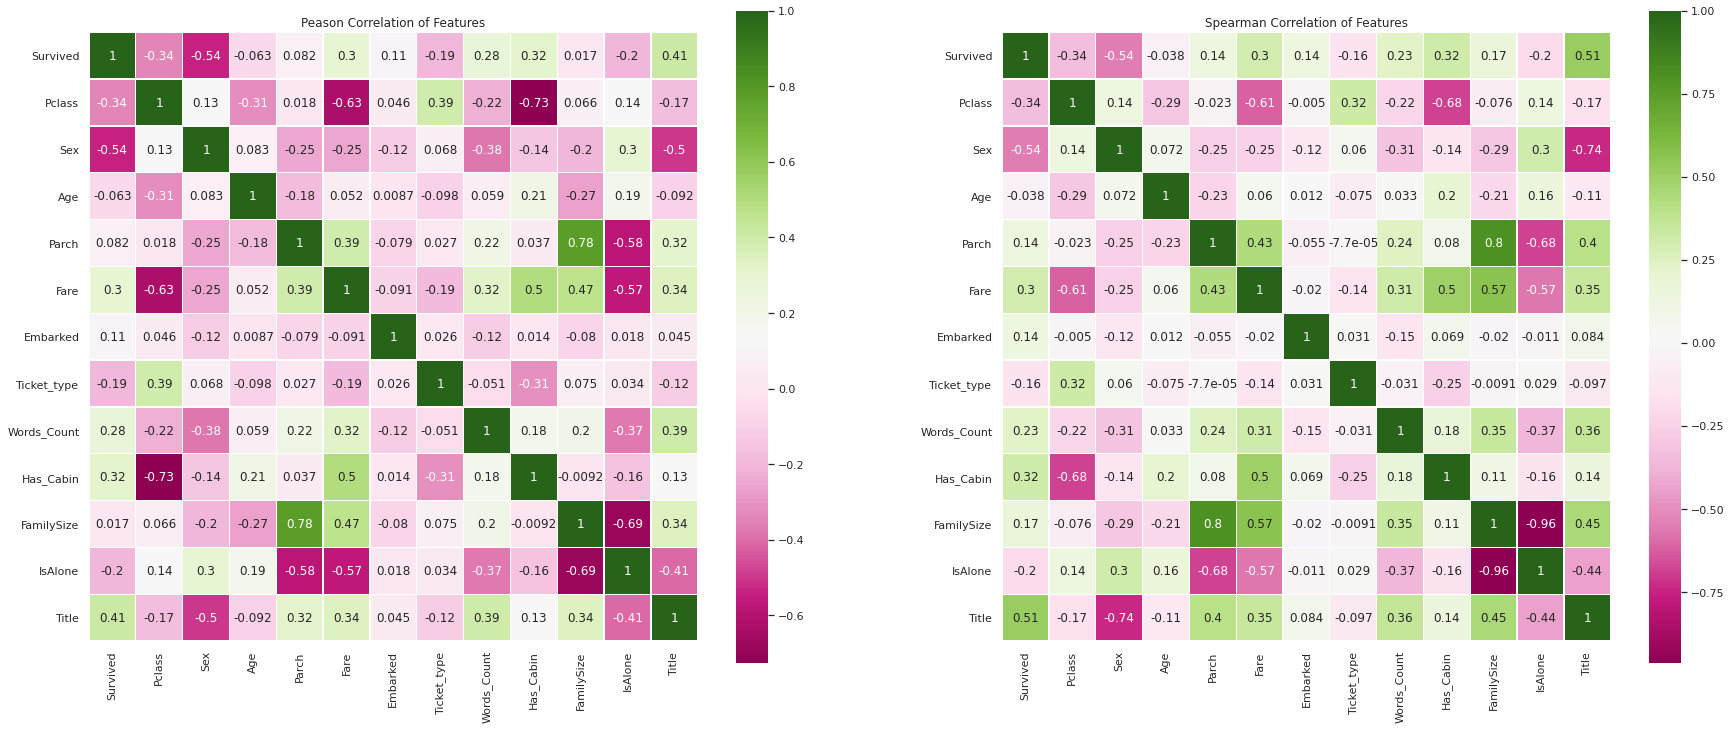

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (30, 12))
sns.heatmap(train.astype(float).corr(method = 'pearson'),linewidths=0.3,vmax=1.0, 
            square=True, cmap='PiYG', linecolor='white', annot=True, ax = ax[0])

sns.heatmap(train.astype(float).corr(method = 'spearman'),linewidths=0.3,vmax=1.0, 
            square=True, cmap='PiYG', linecolor='white', annot=True, ax = ax[1])

ax[0].title.set_text('Peason Correlation of Features')
ax[1].title.set_text('Spearman Correlation of Features')

fig.show()

### Final Processed Data

In [17]:
y_train = train['Survived'].ravel() # Creates an array of the train labels
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test labels

## 3.1 Making Ground Truth for Test Set (Evaluation Purpose Only)
Here I am downloading the output of the test set that produces a score of 1.00 (100% Accurate Prediction). However, I am not going to submit it like others just to get at top 1% submission. Rather I am going to perform a performance analysis.

In [18]:
test_data_with_labels = pd.read_csv("https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv")
test_data = pd.read_csv('../input/titanic/test.csv')

for i, name in enumerate(test_data_with_labels['name']):
    if '"' in name:
        test_data_with_labels['name'][i] = re.sub('"', '', name)
        
for i, name in enumerate(test_data['Name']):
    if '"' in name:
        test_data['Name'][i] = re.sub('"', '', name)
        
survived = []

for name in test_data['Name']:
    survived.append(int(test_data_with_labels.loc[test_data_with_labels['name'] == name]['survived'].values[-1]))


# Ground Label Evaluation
y_true = np.array(survived)

# 2. Classification: 
## 2.1 XGBoost
Here we choose the eXtremely famous library for boosted tree learning model, [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html). It was built to optimize large-scale boosted tree algorithms. To dig dipper into its use and fine tuning for your custom model feel free to look at the [python package documentation](https://xgboost.readthedocs.io/en/latest/python/index.html) dedicated for XGBoost. 

Just a quick run down of the XGBoost parameters used in the model:
* `max_depth:` How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.
* `gamma:` minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
* `eta:` step size shrinkage used in each boosting step to prevent overfitting

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [19]:
import xgboost as xgb



gbm = xgb.XGBClassifier(n_estimators= 100, 
                        max_depth = 4,
                        gamma = 0.9,
                        nthread = -1,
                        scale_pos_weight=1,
                       random_state = 3101)


gbm.fit(x_train, y_train)
xgb_predictions = gbm.predict(x_test)

score_gbm = gbm.score(x_train, y_train)
print(f'Random Forest Classifier score (Train Accuracy): {score_gbm}')

test_acc_gbm = accuracy_score(y_true, xgb_predictions)
print(f'Random Forest Classifier score (Test Accuracy): {test_acc_gbm}')


# Making Submission DataFrame
xgb_submission = pd.DataFrame({ 'PassengerId': PassengerId,
                                   'Survived': xgb_predictions })

# Writing to csv file
xgb_submission.head()
xgb_submission.to_csv('xgb_submission.csv', index = False)

Random Forest Classifier score (Train Accuracy): 0.9001122334455668
Random Forest Classifier score (Test Accuracy): 0.7488038277511961


### 2.1.1 Feature Importance Map
To have a look at the importance of the feature elements, you can use the following section

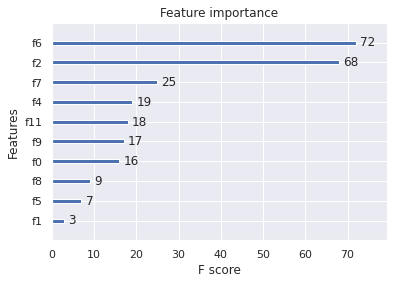

In [20]:
xgb.plot_importance(gbm)

### 2.1.2 Decision Tree Visualization
To have a look at the original decision tree boundary, just have a look at the follwoing decision tree. Feel free to play with some parameters. 

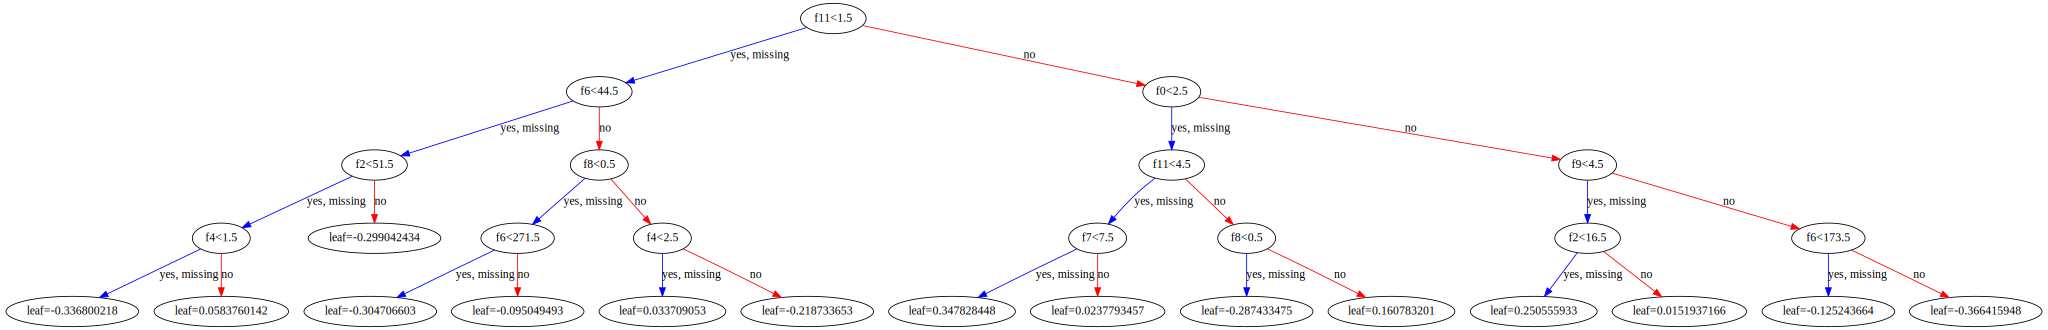

In [21]:
xgb.to_graphviz(gbm, num_trees=2)

## 2.2 Random Forest Classifier

In [22]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 4, 
                            max_features  = 5,
                            random_state = 216)  
rfc.fit(x_train, y_train)
score_rfc = rfc.score(x_train, y_train)
out_rfc = rfc.predict(x_test)
print(f'Random Forest Classifier score (Train Accuracy): {score_rfc}')

test_acc_rfc = accuracy_score(y_true, out_rfc)
print(f'Random Forest Classifier score (Test Accuracy): {test_acc_rfc}')



# Making Submission DataFrame
rfc_submission = pd.DataFrame({ 'PassengerId': PassengerId,
                                   'Survived': out_rfc })

# Writing to csv file
rfc_submission.head()
rfc_submission.to_csv('rfc_submission.csv', index = False)

Random Forest Classifier score (Train Accuracy): 0.9584736251402918
Random Forest Classifier score (Test Accuracy): 0.8014354066985646


## 2.3 K- Nearest Neighbour Classifier 

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
score_knn = knn.score(x_train, y_train)
out_knn = knn.predict(x_test)
 

print(f'K- Nearest Neighbour ClassifierClassifier score (Train Accuracy): {score_knn}')
test_acc_knn = accuracy_score(y_true, out_knn)
print(f'K- Nearest Neighbour Classifier Classifier score (Test Accuracy): {test_acc_knn}')

K- Nearest Neighbour ClassifierClassifier score (Train Accuracy): 0.7968574635241302
K- Nearest Neighbour Classifier Classifier score (Test Accuracy): 0.4258373205741627


## 2.4 Support Vector Machine Classifier

In [24]:
from sklearn.svm import SVC

#SVM
# ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
svc = SVC(C = 5, kernel = 'linear', random_state = 8)
svc.fit(x_train, y_train)
score_svc = svc.score(x_train, y_train)
out_svc = svc.predict(x_test)    
print(f'Support Vector Machine Classifier score (Train Accuracy): {score_svc}')
test_acc_svc = accuracy_score(y_true, out_svc)
print(f'K- Support Vector Machine  Classifier Classifier score (Test Accuracy): {test_acc_svc}')

Support Vector Machine Classifier score (Train Accuracy): 0.8148148148148148
K- Support Vector Machine  Classifier Classifier score (Test Accuracy): 0.7727272727272727


## 2.5 Voting All Classifiers

In [25]:
from sklearn.ensemble import VotingClassifier

#voting classifier    
vclf = VotingClassifier(estimators=[('gb',gbm), ('rf',rfc),('knn',knn) , ('svm',svc)], voting='hard', weights=[2,3,1,2])
vclf.fit(x_train, y_train)
out_vclf = vclf.predict(x_test)
score_voting = vclf.score(x_train, y_train)
print(f'Voting Classifier score (Train Accuracy): {score_voting}')
test_acc_voting = accuracy_score(y_true, out_vclf)
print(f'Voting Classifier score (Test Accuracy): {test_acc_voting}')

Voting Classifier score (Train Accuracy): 0.9147025813692481
Voting Classifier score (Test Accuracy): 0.7870813397129187


# 3. Evaluation

 

In [26]:
classifier = ['XGBoost', 	'RandomForest', 'KNN', 'SVC', 'VotingEnsemble']
train_acc  = [score_gbm,	score_rfc,	score_knn, score_svc, score_voting]
test_acc   = [test_acc_gbm, 	test_acc_rfc, 	test_acc_knn, test_acc_svc, test_acc_voting]

score_df = pd.DataFrame({'classifier': classifier, 'train_acc': train_acc, 'test_acc': test_acc})
score2 = score_df.copy()
score_df.train_acc = (np.floor(score_df.train_acc*10000)/100).map('{:,.2f}'.format)
score_df.test_acc = (np.floor(score_df.test_acc*10000)/100).map('{:,.2f}'.format)
score_df

,classifier,train_acc,test_acc
0,XGBoost,90.01,74.88
1,RandomForest,95.84,80.14
2,KNN,79.68,42.58
3,SVC,81.48,77.27
4,VotingEnsemble,91.47,78.70


In [27]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Train Acc', x=score_df.classifier, y=score_df.train_acc, text = score_df.train_acc),
    go.Bar(name='Test Acc', x=score_df.classifier, y=score_df.test_acc, text = score_df.test_acc)
])



# Change the bar mode
fig.update_layout(barmode='group', 
                  title='Performance Comparison of the Classifiers', title_x = 0.5,
                  yaxis_title = 'Accuracy (%)',
                  xaxis_title = 'Classifier')
fig.update_traces(texttemplate='%{text:.s} %', textposition='outside')
fig.show()

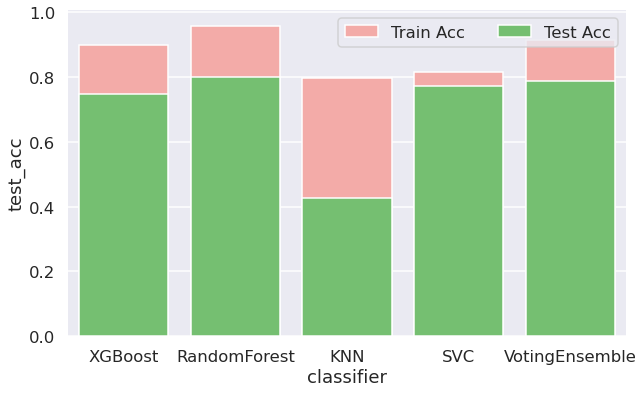

In [28]:
sns.set_context('talk')

f, ax = plt.subplots(figsize = (10,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'classifier', y = 'train_acc', data = score2,
            label = 'Train Acc', color = 'r', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'classifier', y = 'test_acc', data = score2,
            label = 'Test Acc', color = 'g', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'upper right')
sns.despine(left = True, bottom = True)
# plt.show()

In [29]:
score_df

,classifier,train_acc,test_acc
0,XGBoost,90.01,74.88
1,RandomForest,95.84,80.14
2,KNN,79.68,42.58
3,SVC,81.48,77.27
4,VotingEnsemble,91.47,78.70


# More is Coming in Ensemble